<h2 align=center> Facial Expression Recognition</h2>

### Task 1: Import Libraries

In [1]:
!pip install utils
!pip install livelossplot

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version: 2.2.0


### Task 2: Plot Sample Images

In [3]:
# utils.datasets.fer.plot_example_images(plt).show()

In [4]:
!pip install kaggle

In [5]:
import os
os.mkdir('/content/kaggle/')

In [6]:
import json
token = {"username":"prabhatale","key":"e0417b03e7d4b9f5ddf4f924fd1f995f"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [9]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [10]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [11]:
!chmod 600 /root/.kaggle/kaggle.json

In [12]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset -p /content

 80% 97.0M/121M [00:03<00:01, 21.6MB/s]
100% 121M/121M [00:03<00:00, 40.5MB/s] 


In [13]:
import zipfile
archive = zipfile.ZipFile("/content/face-expression-recognition-dataset.zip","r")
archive.extractall("/content/")

In [14]:
train_dir_path = "/content/images/train/"
valid_dir_path = "/content/images/validation/"
categories = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [15]:
# Visualizing Training Datasets
def path_to_images(dataset_dir):
  images_path = []
  for category in categories:
    path = os.path.join(dataset_dir,category)
    i = 0 
    for image in os.listdir(path):
      if i==5:
        break
      images_path.append(os.path.join(path,image))
      i+=1
  return images_path

In [16]:
training_image_paths = path_to_images(train_dir_path)
print(training_image_paths)
print(len(training_image_paths))

['/content/images/train/angry/5587.jpg', '/content/images/train/angry/33162.jpg', '/content/images/train/angry/30834.jpg', '/content/images/train/angry/4877.jpg', '/content/images/train/angry/4992.jpg', '/content/images/train/disgust/7143.jpg', '/content/images/train/disgust/19807.jpg', '/content/images/train/disgust/7386.jpg', '/content/images/train/disgust/23982.jpg', '/content/images/train/disgust/21799.jpg', '/content/images/train/fear/34504.jpg', '/content/images/train/fear/27746.jpg', '/content/images/train/fear/19623.jpg', '/content/images/train/fear/11804.jpg', '/content/images/train/fear/34171.jpg', '/content/images/train/happy/29065.jpg', '/content/images/train/happy/32287.jpg', '/content/images/train/happy/849.jpg', '/content/images/train/happy/17035.jpg', '/content/images/train/happy/8265.jpg', '/content/images/train/neutral/12186.jpg', '/content/images/train/neutral/5465.jpg', '/content/images/train/neutral/22907.jpg', '/content/images/train/neutral/1080.jpg', '/content/im

In [17]:
# Plotting Graph
import cv2
def visualize_images(paths,rows,columns):
  fig = plt.figure(figsize=(15,15))
  rows = rows
  columns = columns
  plt.title('Visualizing Expressions datasets')
  for i in range(1,rows*columns+1):
    img_array = cv2.imread(paths[i-1])
    fig.add_subplot(rows,columns,i)
    fig.subplots_adjust(hspace=1)
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.xlabel(paths[i-1].split('/')[4])
  return plt.show()

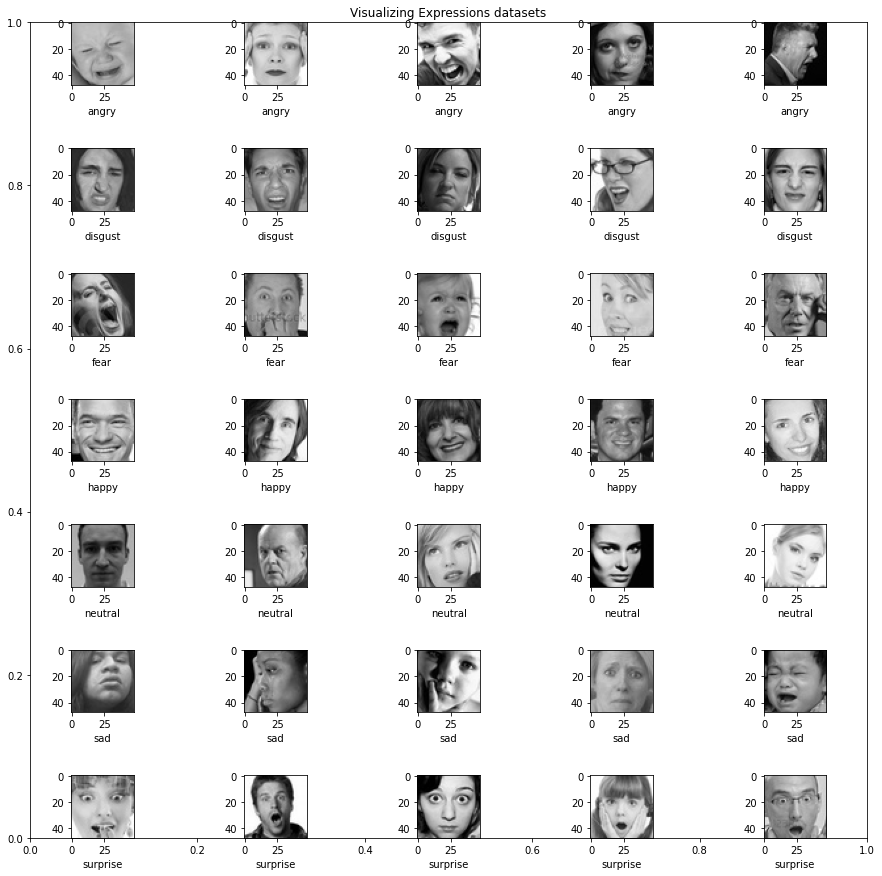

In [18]:
# Training Image Visualization
visualize_images(training_image_paths,7,5)

In [19]:
# Visualizing Validation Datasets
validation_image_paths = path_to_images(dataset_dir = valid_dir_path)
print(validation_image_paths)
print(len(validation_image_paths))

['/content/images/validation/angry/11561.jpg', '/content/images/validation/angry/19485.jpg', '/content/images/validation/angry/3632.jpg', '/content/images/validation/angry/34778.jpg', '/content/images/validation/angry/26124.jpg', '/content/images/validation/disgust/4002.jpg', '/content/images/validation/disgust/2275.jpg', '/content/images/validation/disgust/33561.jpg', '/content/images/validation/disgust/3521.jpg', '/content/images/validation/disgust/4312.jpg', '/content/images/validation/fear/25710.jpg', '/content/images/validation/fear/35629.jpg', '/content/images/validation/fear/3722.jpg', '/content/images/validation/fear/17710.jpg', '/content/images/validation/fear/27509.jpg', '/content/images/validation/happy/17552.jpg', '/content/images/validation/happy/35117.jpg', '/content/images/validation/happy/19008.jpg', '/content/images/validation/happy/21778.jpg', '/content/images/validation/happy/33762.jpg', '/content/images/validation/neutral/24962.jpg', '/content/images/validation/neut

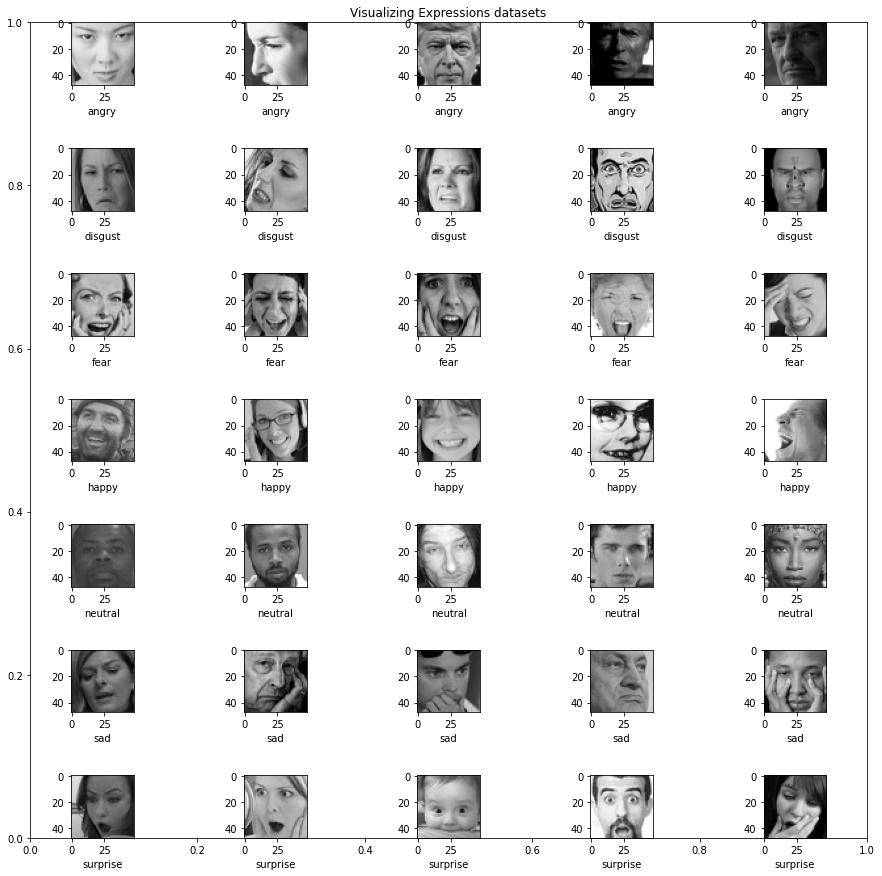

In [20]:
# Validation Image Visualization
visualize_images(validation_image_paths,7,5)

In [21]:
# Exploring the distribution of datasets
# Training Image Distribution
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
4103 fear images
3205 surprise images
4982 neutral images
7164 happy images
4938 sad images
3993 angry images


In [22]:
# Validation Image Distribution
for expression in os.listdir(valid_dir_path):
    print(str(len(os.listdir(valid_dir_path + expression))) + " " + expression + " images")

111 disgust images
1018 fear images
797 surprise images
1216 neutral images
1825 happy images
1139 sad images
960 angry images


In [23]:
# Generating 36 new happy faces to make happy faces dataset equal to 7200
import random
selected_samples = []
generator_dir = "/content/images/train/happy/"
total_no_of_happy_expressions = len(os.listdir(generator_dir))
selection = random.sample(os.listdir("/content/images/train/happy"),36)
for choices in selection:
  choice = os.path.join(generator_dir,choices)
  selected_samples.append(choice)
print(total_no_of_happy_expressions)
print(selection)
print(len(selection))
print(selected_samples)
print(len(selected_samples))

7164
['3655.jpg', '25987.jpg', '32919.jpg', '19163.jpg', '24229.jpg', '35047.jpg', '28514.jpg', '30135.jpg', '3680.jpg', '8122.jpg', '28536.jpg', '1662.jpg', '9057.jpg', '28324.jpg', '13589.jpg', '34514.jpg', '34888.jpg', '32236.jpg', '8759.jpg', '17145.jpg', '34832.jpg', '6181.jpg', '19282.jpg', '2222.jpg', '22061.jpg', '15599.jpg', '6804.jpg', '4276.jpg', '26694.jpg', '8935.jpg', '26430.jpg', '8775.jpg', '13749.jpg', '30166.jpg', '8095.jpg', '13222.jpg']
36
['/content/images/train/happy/3655.jpg', '/content/images/train/happy/25987.jpg', '/content/images/train/happy/32919.jpg', '/content/images/train/happy/19163.jpg', '/content/images/train/happy/24229.jpg', '/content/images/train/happy/35047.jpg', '/content/images/train/happy/28514.jpg', '/content/images/train/happy/30135.jpg', '/content/images/train/happy/3680.jpg', '/content/images/train/happy/8122.jpg', '/content/images/train/happy/28536.jpg', '/content/images/train/happy/1662.jpg', '/content/images/train/happy/9057.jpg', '/conte

In [24]:
import os
os.mkdir('/content/flipped_image/')

In [25]:
import cv2
import os 
flipped_image_path = "/content/flipped_image/"
for imgpath in selected_samples:
  split_imgpath = imgpath.split('.')[0]
  split_imgpath = split_imgpath.split('/')[-1]
  new_imgpath = split_imgpath + '_' + 'hflip'
  img = cv2.imread(imgpath)
  flipped_img = cv2.flip(img,1)
  cv2.imwrite(os.path.join(flipped_image_path,str(new_imgpath) +'.jpg'),flipped_img)


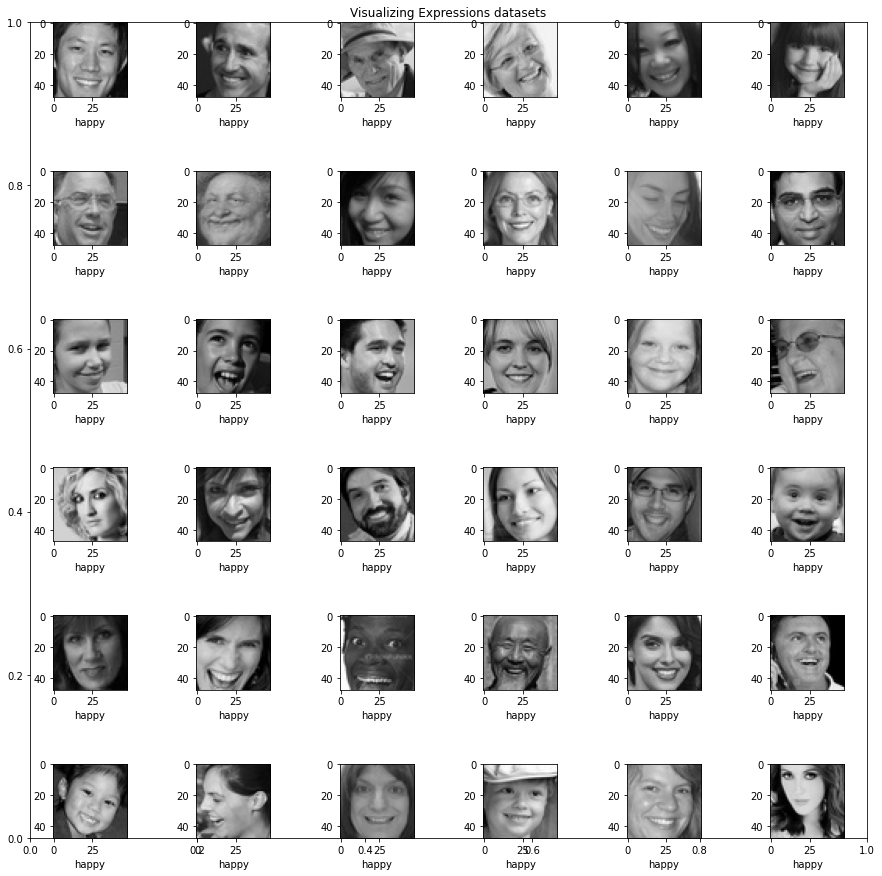

In [26]:
visualize_images(selected_samples,6,6)

In [27]:
flippedimages_path = []
for img in os.listdir(flipped_image_path):
  path = os.path.join(flipped_image_path,img)
  flippedimages_path.append(path)
print(flippedimages_path)
print(len(flippedimages_path))

['/content/flipped_image/34832_hflip.jpg', '/content/flipped_image/2222_hflip.jpg', '/content/flipped_image/34888_hflip.jpg', '/content/flipped_image/22061_hflip.jpg', '/content/flipped_image/24229_hflip.jpg', '/content/flipped_image/3680_hflip.jpg', '/content/flipped_image/8775_hflip.jpg', '/content/flipped_image/13749_hflip.jpg', '/content/flipped_image/30135_hflip.jpg', '/content/flipped_image/32919_hflip.jpg', '/content/flipped_image/26430_hflip.jpg', '/content/flipped_image/28514_hflip.jpg', '/content/flipped_image/6804_hflip.jpg', '/content/flipped_image/13222_hflip.jpg', '/content/flipped_image/34514_hflip.jpg', '/content/flipped_image/8935_hflip.jpg', '/content/flipped_image/28536_hflip.jpg', '/content/flipped_image/19282_hflip.jpg', '/content/flipped_image/26694_hflip.jpg', '/content/flipped_image/17145_hflip.jpg', '/content/flipped_image/8122_hflip.jpg', '/content/flipped_image/13589_hflip.jpg', '/content/flipped_image/28324_hflip.jpg', '/content/flipped_image/4276_hflip.jpg'

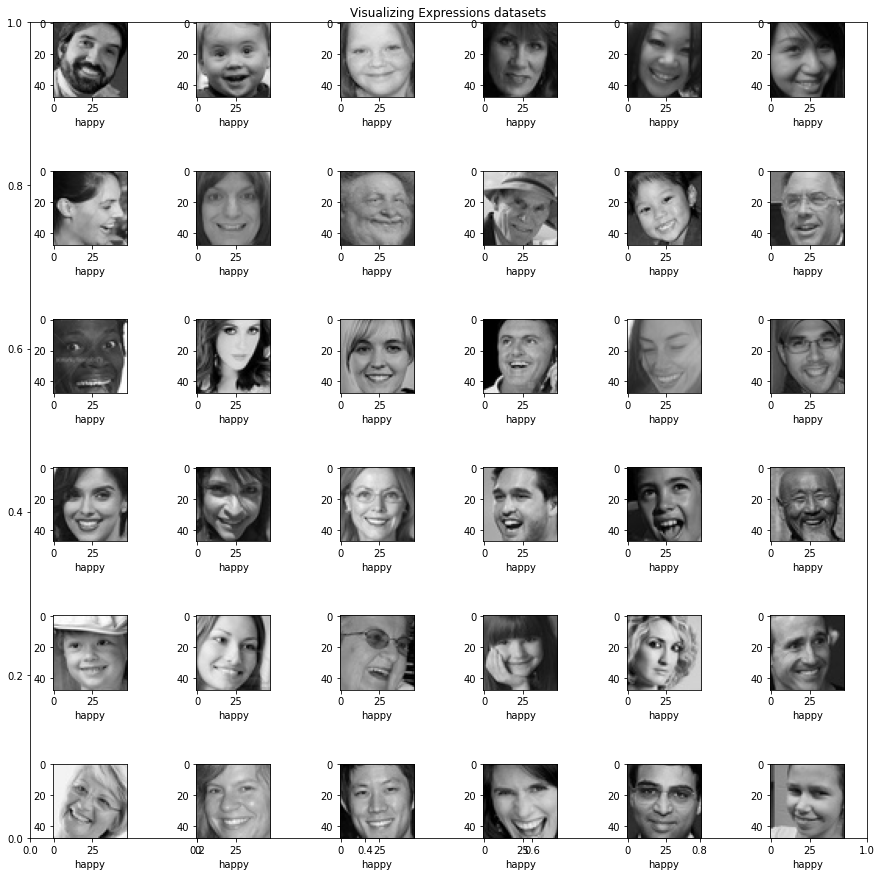

In [28]:
# visualize_images(flippedimages_path,6,6)
import cv2
fig = plt.figure(figsize=(15,15))
rows = 6
columns = 6
plt.title('Visualizing Expressions datasets')
for i in range(1,rows*columns+1):
  img_array = cv2.imread(flippedimages_path[i-1])
  fig.add_subplot(rows,columns,i)
  fig.subplots_adjust(hspace=1)
  plt.imshow(img_array)
  plt.xlabel('happy')


In [29]:
# Populating Happy emotion datasets
import cv2
import os 
for imgpath in selected_samples:
  split_imgpath = imgpath.split('.')[0]
  new_imgpath = split_imgpath + '_' + 'hflip'
  img = cv2.imread(imgpath)
  flipped_img = cv2.flip(img,1)
  cv2.imwrite(new_imgpath +'.jpg',flipped_img)


In [30]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
4103 fear images
3205 surprise images
4982 neutral images
7200 happy images
4938 sad images
3993 angry images


In [31]:
import random
def select_random_generator_images(generator_dir,no_of_samples):
  selected_samples = []
  generator_dir = generator_dir
  selection = random.sample(os.listdir(generator_dir),no_of_samples)
  for choices in selection:
    choice = os.path.join(generator_dir,choices)
    selected_samples.append(choice)
  return selected_samples

In [32]:
# Generating Neutral images (2218 new images)

In [33]:
# Random Selection Of 1218 Neutral expression images)
neutral_samples_selection = select_random_generator_images(generator_dir="/content/images/train/neutral",no_of_samples=1218)
print(neutral_samples_selection)
print(len(neutral_samples_selection))

['/content/images/train/neutral/30677.jpg', '/content/images/train/neutral/35091.jpg', '/content/images/train/neutral/34021.jpg', '/content/images/train/neutral/28107.jpg', '/content/images/train/neutral/28834.jpg', '/content/images/train/neutral/11809.jpg', '/content/images/train/neutral/16578.jpg', '/content/images/train/neutral/6967.jpg', '/content/images/train/neutral/24551.jpg', '/content/images/train/neutral/801.jpg', '/content/images/train/neutral/22180.jpg', '/content/images/train/neutral/4213.jpg', '/content/images/train/neutral/26823.jpg', '/content/images/train/neutral/21011.jpg', '/content/images/train/neutral/18234.jpg', '/content/images/train/neutral/32874.jpg', '/content/images/train/neutral/9218.jpg', '/content/images/train/neutral/26997.jpg', '/content/images/train/neutral/23515.jpg', '/content/images/train/neutral/27678.jpg', '/content/images/train/neutral/19342.jpg', '/content/images/train/neutral/12015.jpg', '/content/images/train/neutral/12017.jpg', '/content/image

In [34]:
# Populating 1228 new generated neutral emotion datasets using horizontal flips
def generate_flipped_samples(samples_selection):
   for imgpath in samples_selection:
     split_imgpath = imgpath.split('.')[0]
     new_imgpath = split_imgpath + '_' + 'hflip'
     img = cv2.imread(imgpath)
     flipped_img = cv2.flip(img,1)
     cv2.imwrite(new_imgpath +'.jpg',flipped_img)

In [35]:
generate_flipped_samples(neutral_samples_selection)

In [36]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
4103 fear images
3205 surprise images
6200 neutral images
7200 happy images
4938 sad images
3993 angry images


In [37]:
# Random Selection Of 1707 
angry_samples_selection = select_random_generator_images(generator_dir = "/content/images/train/angry",no_of_samples=1707)
print(angry_samples_selection)
print(len(angry_samples_selection))

['/content/images/train/angry/13207.jpg', '/content/images/train/angry/23871.jpg', '/content/images/train/angry/15962.jpg', '/content/images/train/angry/1267.jpg', '/content/images/train/angry/18996.jpg', '/content/images/train/angry/33148.jpg', '/content/images/train/angry/30302.jpg', '/content/images/train/angry/17903.jpg', '/content/images/train/angry/4717.jpg', '/content/images/train/angry/27511.jpg', '/content/images/train/angry/2201.jpg', '/content/images/train/angry/18271.jpg', '/content/images/train/angry/24164.jpg', '/content/images/train/angry/19161.jpg', '/content/images/train/angry/28907.jpg', '/content/images/train/angry/28733.jpg', '/content/images/train/angry/22678.jpg', '/content/images/train/angry/5191.jpg', '/content/images/train/angry/834.jpg', '/content/images/train/angry/7300.jpg', '/content/images/train/angry/6319.jpg', '/content/images/train/angry/24084.jpg', '/content/images/train/angry/11877.jpg', '/content/images/train/angry/35854.jpg', '/content/images/train/

In [38]:
generate_flipped_samples(angry_samples_selection)

In [39]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
4103 fear images
3205 surprise images
6200 neutral images
7200 happy images
4938 sad images
5700 angry images


In [40]:
fear_samples_selection = select_random_generator_images(generator_dir="/content/images/train/fear",no_of_samples=1597)
print(fear_samples_selection)
print(len(fear_samples_selection))

['/content/images/train/fear/8978.jpg', '/content/images/train/fear/24218.jpg', '/content/images/train/fear/27941.jpg', '/content/images/train/fear/2233.jpg', '/content/images/train/fear/14023.jpg', '/content/images/train/fear/27189.jpg', '/content/images/train/fear/8822.jpg', '/content/images/train/fear/24170.jpg', '/content/images/train/fear/28822.jpg', '/content/images/train/fear/8939.jpg', '/content/images/train/fear/13634.jpg', '/content/images/train/fear/33604.jpg', '/content/images/train/fear/12322.jpg', '/content/images/train/fear/26718.jpg', '/content/images/train/fear/31093.jpg', '/content/images/train/fear/4135.jpg', '/content/images/train/fear/16085.jpg', '/content/images/train/fear/702.jpg', '/content/images/train/fear/34376.jpg', '/content/images/train/fear/19445.jpg', '/content/images/train/fear/22077.jpg', '/content/images/train/fear/25840.jpg', '/content/images/train/fear/2097.jpg', '/content/images/train/fear/2356.jpg', '/content/images/train/fear/35848.jpg', '/conten

In [41]:
generate_flipped_samples(fear_samples_selection)

In [42]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
5700 fear images
3205 surprise images
6200 neutral images
7200 happy images
4938 sad images
5700 angry images


In [43]:
sad_images_selection = select_random_generator_images(generator_dir="/content/images/train/sad",no_of_samples=1062)
print(sad_images_selection)
print(len(sad_images_selection))

['/content/images/train/sad/21172.jpg', '/content/images/train/sad/31887.jpg', '/content/images/train/sad/15630.jpg', '/content/images/train/sad/10103.jpg', '/content/images/train/sad/18330.jpg', '/content/images/train/sad/35449.jpg', '/content/images/train/sad/12931.jpg', '/content/images/train/sad/2573.jpg', '/content/images/train/sad/10412.jpg', '/content/images/train/sad/34971.jpg', '/content/images/train/sad/12295.jpg', '/content/images/train/sad/9587.jpg', '/content/images/train/sad/20704.jpg', '/content/images/train/sad/13186.jpg', '/content/images/train/sad/29425.jpg', '/content/images/train/sad/441.jpg', '/content/images/train/sad/5380.jpg', '/content/images/train/sad/640.jpg', '/content/images/train/sad/17398.jpg', '/content/images/train/sad/17453.jpg', '/content/images/train/sad/8846.jpg', '/content/images/train/sad/2460.jpg', '/content/images/train/sad/11777.jpg', '/content/images/train/sad/9720.jpg', '/content/images/train/sad/34550.jpg', '/content/images/train/sad/5016.jp

In [44]:
generate_flipped_samples(sad_images_selection)

In [45]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
5700 fear images
3205 surprise images
6200 neutral images
7200 happy images
6000 sad images
5700 angry images


In [46]:
surprise_images_selection = select_random_generator_images(generator_dir="/content/images/train/surprise",no_of_samples=1795)
print(surprise_images_selection)
print(len(surprise_images_selection))

['/content/images/train/surprise/31699.jpg', '/content/images/train/surprise/31763.jpg', '/content/images/train/surprise/425.jpg', '/content/images/train/surprise/8906.jpg', '/content/images/train/surprise/15671.jpg', '/content/images/train/surprise/11980.jpg', '/content/images/train/surprise/27666.jpg', '/content/images/train/surprise/5487.jpg', '/content/images/train/surprise/18845.jpg', '/content/images/train/surprise/22580.jpg', '/content/images/train/surprise/7708.jpg', '/content/images/train/surprise/25892.jpg', '/content/images/train/surprise/25894.jpg', '/content/images/train/surprise/4776.jpg', '/content/images/train/surprise/13104.jpg', '/content/images/train/surprise/2059.jpg', '/content/images/train/surprise/22378.jpg', '/content/images/train/surprise/4932.jpg', '/content/images/train/surprise/23402.jpg', '/content/images/train/surprise/10579.jpg', '/content/images/train/surprise/23268.jpg', '/content/images/train/surprise/18635.jpg', '/content/images/train/surprise/17121.j

In [47]:
generate_flipped_samples(surprise_images_selection)

In [48]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

436 disgust images
5700 fear images
5000 surprise images
6200 neutral images
7200 happy images
6000 sad images
5700 angry images


In [49]:
disgust_images_selection = select_random_generator_images(generator_dir="/content/images/train/disgust",no_of_samples=436)
print(disgust_images_selection)
print(len(disgust_images_selection))

['/content/images/train/disgust/27771.jpg', '/content/images/train/disgust/21422.jpg', '/content/images/train/disgust/16205.jpg', '/content/images/train/disgust/34073.jpg', '/content/images/train/disgust/15027.jpg', '/content/images/train/disgust/5168.jpg', '/content/images/train/disgust/35296.jpg', '/content/images/train/disgust/28232.jpg', '/content/images/train/disgust/32717.jpg', '/content/images/train/disgust/33974.jpg', '/content/images/train/disgust/22749.jpg', '/content/images/train/disgust/16452.jpg', '/content/images/train/disgust/2389.jpg', '/content/images/train/disgust/3865.jpg', '/content/images/train/disgust/8512.jpg', '/content/images/train/disgust/28851.jpg', '/content/images/train/disgust/22196.jpg', '/content/images/train/disgust/2795.jpg', '/content/images/train/disgust/3626.jpg', '/content/images/train/disgust/30141.jpg', '/content/images/train/disgust/7733.jpg', '/content/images/train/disgust/32332.jpg', '/content/images/train/disgust/5692.jpg', '/content/images/t

In [50]:
generate_flipped_samples(disgust_images_selection)

In [51]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

872 disgust images
5700 fear images
5000 surprise images
6200 neutral images
7200 happy images
6000 sad images
5700 angry images


In [52]:
!rm -rf "/content/preview/"

In [53]:
import os
os.mkdir('/content/preview/')

In [54]:
angry_dir_path = "/content/images/train/angry/"
disgust_dir_path = "/content/images/train/disgust/"
fear_dir_path = "/content/images/train/fear/"
happy_dir_path = "/content/images/train/happy/"
neutral_dir_path = "/content/images/train/neutral/"
sad_dir_path = "/content/images/train/sad/"
surprise_dir_path = "/content/images/train/surprise/"

In [55]:
# Generating disgust images using image augmentation(rotation,shearing and brightness)

In [58]:
#  Importing necessary functions 
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 
   
# Initialising the ImageDataGenerator class. 
# We will pass in the augmentation parameters in the constructor. 
datagen = ImageDataGenerator( 
        rotation_range = 30, 
        samplewise_center=True,samplewise_std_normalization=True,zca_whitening=True,
        brightness_range = (0.6, 1.4))
for img in os.listdir(disgust_dir_path):
  # Loading a sample image  
  img = load_img(os.path.join(disgust_dir_path,img))  
  # Converting the input sample image to an array 
  x = img_to_array(img) 
  # Reshaping the input image 
  x = x.reshape((1, ) + x.shape)  
    
  # Generating and saving 5 augmented samples  
  # using the above defined parameters.  
  i = 0
  for batch in datagen.flow(x, batch_size = 1, 
                            save_to_dir =disgust_dir_path,  
                            save_prefix ='image', save_format ='jpg'): 
      i += 1
      if i > 8: 
          break

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [59]:
for expression in os.listdir(train_dir_path):
    print(str(len(os.listdir(train_dir_path + expression))) + " " + expression + " images")

6304 disgust images
5700 fear images
5000 surprise images
6200 neutral images
7200 happy images
6000 sad images
5700 angry images


In [ ]:
# #  Importing necessary functions 
# from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img 
   
# # Initialising the ImageDataGenerator class. 
# # We will pass in the augmentation parameters in the constructor. 
# datagen = ImageDataGenerator( 
#         rotation_range = 30, 
#         samplewise_center=True,samplewise_std_normalization=True,
#         brightness_range = (0.6, 1.4))
# selection_for_neutral_images = select_random_generator_images(generator_dir=neutral_dir_path,no_of_samples=1000)
# for img in selection_for_neutral_images:
#   # Loading a sample image  
#   img = load_img(os.path.join(path,img))  
#   # Converting the input sample image to an array 
#   x = img_to_array(img) 
#   # Reshaping the input image 
#   x = x.reshape((1, ) + x.shape)  
    
#   # Generating and saving 5 augmented samples  
#   # using the above defined parameters.  
#   i = 0
#   for batch in datagen.flow(x, batch_size = 1, 
#                             save_to_dir = neutral_dir_path,  
#                             save_prefix ='image', save_format ='jpg'): 
#       i += 1
#       if i == 1: 
#           break

In [61]:
import cv2
horizontal_flip_img_array = cv2.imread("/content/flipped_image/13222_hflip.jpg")
print(horizontal_flip_img_array)

[[[ 91  91  91]
  [ 43  43  43]
  [ 54  54  54]
  ...
  [ 58  58  58]
  [ 87  87  87]
  [ 41  41  41]]

 [[ 80  80  80]
  [ 43  43  43]
  [ 69  69  69]
  ...
  [ 57  57  57]
  [ 79  79  79]
  [ 74  74  74]]

 [[ 67  67  67]
  [ 51  51  51]
  [ 74  74  74]
  ...
  [ 49  49  49]
  [ 68  68  68]
  [ 85  85  85]]

 ...

 [[ 15  15  15]
  [ 11  11  11]
  [ 29  29  29]
  ...
  [193 193 193]
  [178 178 178]
  [172 172 172]]

 [[ 10  10  10]
  [ 14  14  14]
  [  8   8   8]
  ...
  [192 192 192]
  [184 184 184]
  [171 171 171]]

 [[ 12  12  12]
  [ 18  18  18]
  [ 19  19  19]
  ...
  [197 197 197]
  [188 188 188]
  [187 187 187]]]


In [64]:
print(train_dir_path)
print(valid_dir_path)

/content/images/train/
/content/images/validation/


### Task 3: Generate Training and Validation Batches

In [65]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory("/content/images/train/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(rescale=1./255)
validation_generator = datagen_validation.flow_from_directory("/content/images/validation/",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 42104 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


### Task 4: Create CNN Model

In [66]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Task 6: Train and Evaluate Model

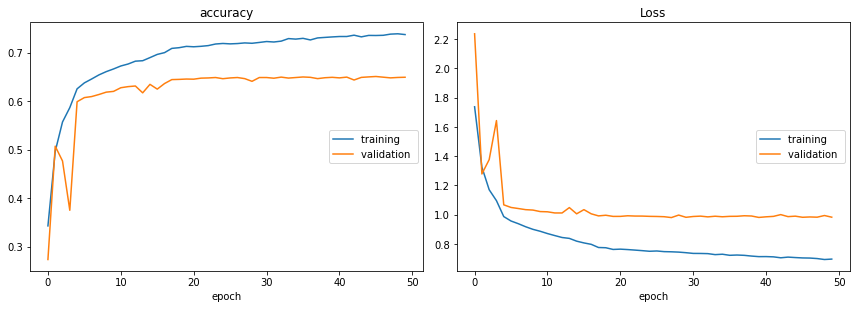

accuracy
	training         	 (min:    0.343, max:    0.739, cur:    0.737)
	validation       	 (min:    0.274, max:    0.651, cur:    0.649)
Loss
	training         	 (min:    0.693, max:    1.737, cur:    0.696)
	validation       	 (min:    0.980, max:    2.236, cur:    0.983)

Epoch 00050: saving model to model_weights.h5
657/657 [==============================] - 21s 32ms/step - loss: 0.6960 - accuracy: 0.7371 - val_loss: 0.9825 - val_accuracy: 0.6491 - lr: 1.0000e-05
CPU times: user 20min 57s, sys: 4min 16s, total: 25min 13s
Wall time: 17min 38s


In [67]:
%%time

epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Task 7: Represent Model as JSON String

In [68]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [70]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
# Rename model weights as faceexpression_weights.h5 and faceexpression.json

In [71]:
!mv "/content/faceexpression_weights.h5" "/content/gdrive/My Drive/Artificial Intelligence/"
!mv "/content/faceexpression.json" "/content/gdrive/My Drive/Artificial Intelligence/"